# FLOSS: Free Lunch in Open-vocabulary Semantic Segmentation

## Reproducibility Notebook

Objective: help you test custom unsupervised ranking metrics quickly and beat our entropy baseline.

This notebook uses **CLIP-DINOiser** as the base model and **Cityscapes** as the dataset. Key FLOSS insight: for each class, a small set of strong templates can outperform the conventional average over all 80 templates. We rank templates with your metric (entropy by default), select top templates per class, and evaluate on validation mIoU.

### Quick Disclaimer (Speed vs Exact Reproduction)

This notebook prioritizes speed, so results may not match the paper at 100% even with entropy.

1. **Resolution:** notebook default is `ORIGINAL_RESOLUTION = (1024, 512)` for faster ranking. For closest match to the original implementation, set it to `(1024, 2048)` in the **Compute Rankings** cell (Cityscapes native resolution).
2. **Training subset:** notebook default uses only a subset via `NUM_IMAGES = 250`. Set `NUM_IMAGES = None` in the training-feature loading cell to use all 2,975 Cityscapes training images.
3. **Inference strategy:** the original implementation uses sliding-window inference in `mmseg/models/segmentors/encoder_decoder.py` and `mmseg/models/segmentors/clip_dinoiser/dinoclip_inferencer.py`; this notebook instead loads precomputed full vision feature maps and computes cosine similarities directly.

---

### Workflow

1. **Load pre-computed features** from HuggingFace
2. **Compute rankings** on the training set using entropy (default) or your custom metric
3. **Evaluate on validation** with expert fusion mIoU vs baseline and vs paper entropy rankings

### Dataset Structure on HuggingFace

| Folder | Description | Count |
|---|---|---|
| `vision_features_train/` | CLIP-DINOiser features for Cityscapes train images | 2,975 |
| `vision_features_val/` | CLIP-DINOiser features for Cityscapes val images | 500 |
| `gt_val/` | Ground truth segmentation maps for val images | 500 |
| `cityscapes_text_features.pt` | Text features for all 80 templates × 19 classes | 1 |

## Setup

In [1]:
# Setup: works the same on Colab and locally — just run this cell first!
import sys
import os
import subprocess

IN_COLAB = 'google.colab' in sys.modules

def need_install():
    """Check if we need to install (key packages missing)."""
    for pkg in ["numpy", "torch", "matplotlib"]:
        try:
            __import__(pkg)
        except ImportError:
            return True
    return False

def run_pip(args):
    if IN_COLAB:
        get_ipython().system(" ".join([sys.executable, "-m", "pip"] + args))
    else:
        subprocess.check_call([sys.executable, "-m", "pip"] + args, cwd=os.getcwd())

if IN_COLAB:
    if not os.path.exists('/content/FLOSS'):
        print("Cloning FLOSS repo...")
        get_ipython().system("git clone https://github.com/yasserben/FLOSS.git /content/FLOSS")
    os.chdir('/content/FLOSS')
    sys.path.insert(0, '/content/FLOSS')
    if need_install():
        print("Installing dependencies for Colab...")
        run_pip(["install", "-q", "torch", "torchvision", "--index-url", "https://download.pytorch.org/whl/cu121"])
        run_pip(["install", "-q", "open-clip-torch", "einops", "ftfy", "regex", "tqdm", "omegaconf", "huggingface_hub", "datasets", "matplotlib", "seaborn", "pandas"])
        print("Done.")
    print("Colab ready.")
else:
    # Local: ensure we're in project root (where rankings/, notebooks/, etc. live)
    cwd = os.getcwd()
    if os.path.basename(cwd) == "notebooks":
        os.chdir("..")
    elif not os.path.exists("rankings") and os.path.exists("../rankings"):
        os.chdir("..")
    project_root = os.getcwd()
    sys.path.insert(0, project_root)
    if need_install():
        print("Installing notebook dependencies...")
        run_pip(["install", "-q", "numpy", "torch", "torchvision", "matplotlib", "seaborn", "tqdm", "huggingface_hub", "datasets", "open-clip-torch", "einops", "ftfy", "regex", "omegaconf", "pandas"])
        print("Done.")
    print(f"Ready. Working directory: {os.getcwd()}")

Ready. Working directory: /home/nvme/benigmim/projects/FLOSS


In [2]:
# Import libraries
import os
import json
import numpy as np
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Configuration

In [3]:
# Configuration
DATASET = "cityscapes"
HF_REPO = "yasserben/floss-features"

# Cityscapes class names
CLASS_NAMES = [
    "road", "sidewalk", "building", "wall", "fence", "pole",
    "traffic light", "traffic sign", "vegetation", "terrain", "sky",
    "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"
]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Dataset: {DATASET}")
print(f"Classes: {NUM_CLASSES}")

Dataset: cityscapes
Classes: 19


In [4]:
# ImageNet Templates (80 prompts)
IMAGENET_TEMPLATES = [
    'a bad photo of a {}.', 'a photo of many {}.', 'a sculpture of a {}.',
    'a photo of the hard to see {}.', 'a low resolution photo of the {}.',
    'a rendering of a {}.', 'graffiti of a {}.', 'a bad photo of the {}.',
    'a cropped photo of the {}.', 'a tattoo of a {}.', 'the embroidered {}.',
    'a photo of a hard to see {}.', 'a bright photo of a {}.', 'a photo of a clean {}.',
    'a photo of a dirty {}.', 'a dark photo of the {}.', 'a drawing of a {}.',
    'a photo of my {}.', 'the plastic {}.', 'a photo of the cool {}.',
    'a close-up photo of a {}.', 'a black and white photo of the {}.',
    'a painting of the {}.', 'a painting of a {}.', 'a pixelated photo of the {}.',
    'a sculpture of the {}.', 'a bright photo of the {}.', 'a cropped photo of a {}.',
    'a plastic {}.', 'a photo of the dirty {}.', 'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.', 'a photo of the {}.', 'a good photo of the {}.',
    'a rendering of the {}.', 'a {} in a video game.', 'a photo of one {}.',
    'a doodle of a {}.', 'a close-up photo of the {}.', 'a photo of a {}.',
    'the origami {}.', 'the {} in a video game.', 'a sketch of a {}.',
    'a doodle of the {}.', 'a origami {}.', 'a low resolution photo of a {}.',
    'the toy {}.', 'a rendition of the {}.', 'a photo of the clean {}.',
    'a photo of a large {}.', 'a rendition of a {}.', 'a photo of a nice {}.',
    'a photo of a weird {}.', 'a blurry photo of a {}.', 'a cartoon {}.',
    'art of a {}.', 'a sketch of the {}.', 'a embroidered {}.',
    'a pixelated photo of a {}.', 'itap of the {}.', 'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.', 'a plushie {}.', 'a photo of the nice {}.',
    'a photo of the small {}.', 'a photo of the weird {}.', 'the cartoon {}.',
    'art of the {}.', 'a drawing of the {}.', 'a photo of the large {}.',
    'a black and white photo of a {}.', 'the plushie {}.', 'a dark photo of a {}.',
    'itap of a {}.', 'graffiti of the {}.', 'a toy {}.', 'itap of my {}.',
    'a photo of a cool {}.', 'a photo of a small {}.', 'a tattoo of the {}.',
]

NUM_TEMPLATES = len(IMAGENET_TEMPLATES)
print(f"Templates: {NUM_TEMPLATES}")

Templates: 80


## Load Features from HuggingFace

In [5]:
from huggingface_hub import list_repo_files, snapshot_download

def load_features_from_hf(repo_id=HF_REPO, cache_dir="./hf_cache"):
    """Load pre-computed features and create a local snapshot for fast file access."""
    print(f"Loading features from {repo_id}...")

    # Create one local snapshot for all assets used in this notebook.
    local_snapshot_dir = snapshot_download(
        repo_id=repo_id,
        repo_type="dataset",
        cache_dir=cache_dir,
        allow_patterns=[
            "cityscapes_text_features.pt",
            "vision_features_train/*.pt",
            "vision_features_val/*.pt",
            "gt_val/*.png",
        ],
    )

    # Load text features from local snapshot
    text_path = os.path.join(local_snapshot_dir, "cityscapes_text_features.pt")
    text_features = torch.load(text_path, weights_only=False)
    print(f"  Text features: {text_features['per_template'].shape}")
    
    # List all files from HuggingFace
    all_files = list_repo_files(repo_id, repo_type="dataset")
    
    # Training vision features (used for computing rankings)
    train_vision_files = sorted([f for f in all_files if f.startswith("vision_features_train/") and f.endswith(".pt")])
    train_index = {"num_images": len(train_vision_files), "image_paths": train_vision_files}
    print(f"  Train vision features: {train_index['num_images']} images")
    
    # Validation vision features (used for evaluating rankings via mIoU)
    val_vision_files = sorted([f for f in all_files if f.startswith("vision_features_val/") and f.endswith(".pt")])
    val_index = {"num_images": len(val_vision_files), "image_paths": val_vision_files}
    print(f"  Val vision features: {val_index['num_images']} images")
    
    # Ground truth for validation (for mIoU computation)
    gt_files = sorted([f for f in all_files if f.startswith("gt_val/") and f.endswith(".png")])
    gt_index = {"num_images": len(gt_files), "image_paths": gt_files}
    print(f"  Val ground truth: {gt_index['num_images']} images")

    return text_features, train_index, val_index, gt_index, local_snapshot_dir

text_features, train_vision_index, val_vision_index, gt_index, LOCAL_HF_SNAPSHOT = load_features_from_hf()

Loading features from yasserben/floss-features...


Fetching 3976 files:   0%|          | 0/3976 [00:00<?, ?it/s]

  Text features: torch.Size([80, 19, 512])
  Train vision features: 2975 images
  Val vision features: 500 images
  Val ground truth: 500 images


In [6]:
def download_vision_features(image_names, local_snapshot_dir=LOCAL_HF_SNAPSHOT, folder="vision_features_train"):
    """Load vision features from a local HF snapshot for fast access."""
    features = []
    for name in tqdm(image_names, desc=f"Loading {folder} (local)"):
        path = os.path.join(local_snapshot_dir, folder, f"{name}.pt")
        feat = torch.load(path, weights_only=False)
        features.append(feat)
    return features

# Number of training images to use for computing rankings
# Fast default: 250 images. Set to None to use all 2,975 Cityscapes training images (closest to original).
NUM_IMAGES = 500

# Download TRAINING vision features (used for computing unsupervised rankings)
all_train_names = [Path(p).stem for p in train_vision_index['image_paths']]
if NUM_IMAGES is not None:
    image_names = all_train_names[:NUM_IMAGES]
    print(f"Using {len(image_names)} of {len(all_train_names)} available train images (limited for testing)")
else:
    image_names = all_train_names
    print(f"Using all {len(image_names)} available train images")

vision_features = download_vision_features(image_names, folder="vision_features_train")
print(f"\nLoaded {len(vision_features)} train vision feature maps")
print(f"Feature shape: {vision_features[0].shape}")

Using 500 of 2975 available train images (limited for testing)


Loading vision_features_train (local):   0%|          | 0/500 [00:00<?, ?it/s]


Loaded 500 train vision feature maps
Feature shape: torch.Size([1, 512, 28, 56])


---

## The Core Method: Entropy-Based Template Ranking

**This is the key contribution of FLOSS.** We rank templates by measuring the entropy of the predicted probability distribution. Lower entropy means higher confidence, which we use as a proxy for template quality.

**Want to beat our method?** Implement a better metric in the cell below!

In [7]:
# =============================================================================
# We use ENTROPY as our unsupervised metric to rank templates.
# Lower entropy = higher confidence = better template.
#
# To beat FLOSS, implement a better metric below
# =============================================================================

def compute_entropy(probs, dim=1, eps=1e-10):
    """
    Compute entropy of probability distribution.
    
    Lower entropy means the model is more confident in its prediction,
    which we use as a signal that the template is better for that class.
    
    Args:
        probs: Probability tensor [B, C, H, W]
        dim: Dimension along which to compute entropy (class dimension)
        eps: Small value for numerical stability
    
    Returns:
        Entropy values [B, H, W]
    """
    log_probs = torch.log(probs + eps)
    entropy = -(probs * log_probs).sum(dim=dim)
    return entropy


def compute_custom_metric(probs, dim=1, eps=1e-10):
    """
    YOUR CUSTOM METRIC - Implement here to beat FLOSS!
    
    Args:
        probs: Probability tensor [B, C, H, W]
        dim: Class dimension
        eps: Small value for numerical stability
    
    Returns:
        Metric values [B, H, W]
    """
    # TODO: Implement your custom metric here
    raise NotImplementedError("Implement your custom metric here!")


# Metric registry
METRICS = {
    "entropy": {"fn": compute_entropy, "higher_is_better": False},
    # Uncomment and implement compute_custom_metric to use your own metric
    # "custom": {"fn": compute_custom_metric, "higher_is_better": True},  # Set True if higher values are better
}

print("Available metrics:", list(METRICS.keys()))

Available metrics: ['entropy']


---

## Template Ranker

**Important Note:** The `TemplateRanker` class now resizes probability maps to **original image resolution** before computing entropy and argmax. This matches the behavior of `entropy_metric.py` which is used for computing the paper's rankings. 

Bilinear interpolation affects probability distributions, so computing entropy at different resolutions produces different rankings. By resizing first, we ensure the notebook reproduces the exact same template rankings as the actual evaluation code.

In [8]:
class TemplateRanker:
    """
    Ranks templates for each class based on a given metric.
    
    For each template-class pair, we accumulate the metric values
    over all pixels predicted as that class, then rank templates
    by their average metric value.
    """
    
    def __init__(self, text_features, class_names, templates=IMAGENET_TEMPLATES, temperature=0.01, original_resolution=(1024, 2048)):
        self.text_features = text_features
        self.class_names = class_names
        self.templates = templates
        self.temperature = temperature
        self.num_templates = len(templates)
        self.num_classes = len(class_names)
        self.original_resolution = original_resolution  # (H, W) for resizing probabilities to match entropy_metric.py
        self.reset()
    
    def reset(self):
        """Reset accumulated statistics."""
        self.metric_accumulator = defaultdict(lambda: defaultdict(lambda: {"sum": 0.0, "count": 0}))
        self.total_pixels = 0
    
    def compute_segmentation_probs(self, image_features):
        """
        Compute segmentation probabilities for all templates.
        
        Args:
            image_features: Vision features [B, D, H, W]
        
        Returns:
            Probabilities [T, B, C, H, W] for each template
        """
        B, dim, H, W = image_features.shape
        per_template = self.text_features["per_template"].to(image_features.device)  # [T, C, D]
        T, C, D = per_template.shape
        
        # Compute cosine similarity via conv2d (match MaskClipHead.cls_seg)
        image_features_norm = image_features / (image_features.norm(dim=1, keepdim=True) + 1e-6)
        reshaped = per_template.reshape(-1, D)  # [T*C, D]
        output = F.conv2d(image_features_norm, reshaped[:, :, None, None])  # [B, T*C, H, W]
        output = output.reshape(B, T, C, H, W)
        
        # Apply softmax with temperature
        probs = F.softmax(output / self.temperature, dim=2)
        
        return probs.permute(1, 0, 2, 3, 4)  # [T, B, C, H, W]
    
    def update_metrics(self, image_features, metric_name="entropy"):
        """
        Update metric statistics for a batch of images.
        
        Args:
            image_features: Vision features [B, D, H, W]
            metric_name: Name of metric to use
        
        Note: This method resizes probabilities to original resolution before
        computing entropy/argmax to match entropy_metric.py behavior.
        """
        B, _, H_feat, W_feat = image_features.shape
        metric_fn = METRICS[metric_name]["fn"]
        
        # Get original resolution for resizing
        original_h, original_w = self.original_resolution
        
        with torch.inference_mode():
            probs = self.compute_segmentation_probs(image_features)  # [T, B, C, H_feat, W_feat]
        
        # Process templates one at a time (memory efficient)
        template_range = range(self.num_templates)
        # Show progress if tqdm available (disable in non-interactive mode)
        try:
            from tqdm.auto import tqdm as tqdm_auto
            template_range = tqdm_auto(template_range, desc="Templates", leave=False, disable=True)
        except:
            pass
        
        for t_idx in template_range:
            # Keep all operations on the same device to avoid CPU/GPU ping-pong
            template_probs = probs[t_idx]  # [B, C, H_feat, W_feat]
            
            # Match entropy_metric.py: resize before entropy and argmax
            template_probs_resized = F.interpolate(
                template_probs,
                size=(original_h, original_w),
                mode='bilinear',
                align_corners=False
            )  # [B, C, original_h, original_w]
            
            # Compute metrics on RESIZED probabilities (matches entropy_metric.py)
            metric_values = metric_fn(template_probs_resized, dim=1)  # [B, original_h, original_w]
            predictions = template_probs_resized.argmax(dim=1)  # [B, original_h, original_w]
            
            # Accumulate metrics per class
            for c_idx in range(self.num_classes):
                mask = predictions == c_idx
                if mask.any():
                    class_metric = metric_values[mask]
                    self.metric_accumulator[t_idx][c_idx]["sum"] += class_metric.sum().item()
                    self.metric_accumulator[t_idx][c_idx]["count"] += mask.sum().item()
            
            # Free intermediate tensors from this template iteration
            del template_probs, template_probs_resized, metric_values, predictions
        del probs
        
        # Update total_pixels based on RESIZED resolution (matches entropy_metric.py)
        self.total_pixels += B * original_h * original_w
    
    def compute_rankings(self, metric_name="entropy"):
        """
        Compute final template rankings for each class.
        
        Returns:
            Dictionary with rankings per class
        """
        metric_config = METRICS[metric_name]
        if "higher_is_better" in metric_config:
            higher_is_better = bool(metric_config["higher_is_better"])
        elif "lower_is_better" in metric_config:
            higher_is_better = not bool(metric_config["lower_is_better"])
        else:
            # Default to lower-is-better for backward compatibility
            higher_is_better = False
        rankings = {"classes": {}}
        
        for c_idx, class_name in enumerate(self.class_names):
            template_scores = []
            
            for t_idx in range(self.num_templates):
                data = self.metric_accumulator[t_idx][c_idx]
                if data["count"] > 0:
                    avg_metric = data["sum"] / data["count"]
                    pixel_pct = (data["count"] / self.total_pixels) * 100
                else:
                    # No pixels predicted as this class for this template - use NaN
                    avg_metric = float('nan')
                    pixel_pct = 0.0
                
                template_scores.append({
                    "template_id": t_idx,
                    metric_name: avg_metric,
                    "pixel_percentage": pixel_pct
                })
            
            # Filter out templates with NaN values for sorting, but keep them in the list
            valid_scores = [s for s in template_scores if np.isfinite(s[metric_name])]
            invalid_scores = [s for s in template_scores if not np.isfinite(s[metric_name])]
            
            # Sort valid scores by metric
            sorted_scores = sorted(
                valid_scores,
                key=lambda x: x[metric_name],
                reverse=higher_is_better
            )
            # Append invalid scores at the end (they won't have a meaningful rank)
            sorted_scores.extend(invalid_scores)
            
            # Add rank
            for rank, score in enumerate(sorted_scores, 1):
                score["rank"] = rank
            
            rankings["classes"][class_name] = {f"{metric_name}_ranking": sorted_scores}
        
        return rankings

print("TemplateRanker defined.")

TemplateRanker defined.


## Compute Rankings

In [10]:
# Metric is auto-selected from METRICS: use first non-entropy metric if present, else entropy
METRIC_NAME = next((name for name in METRICS if name != "entropy"), "entropy")

# Resolution used for ranking metric computation (speed/accuracy trade-off)
# Fast default for Cityscapes notebook runs: (1024, 512). Use (1024, 2048) for closest match to original implementation (Cityscapes native resolution).
ORIGINAL_RESOLUTION = (1024, 512)

print(f"Computing rankings using: {METRIC_NAME}")
print(f"resolution for entropy computation: {ORIGINAL_RESOLUTION}")

ranker = TemplateRanker(
    text_features=text_features,
    class_names=CLASS_NAMES,
    original_resolution=ORIGINAL_RESOLUTION
)

with torch.inference_mode():
    for feat in tqdm(vision_features, desc="Processing images"):
        feat_device = feat.to(DEVICE, non_blocking=True)
        ranker.update_metrics(feat_device, metric_name=METRIC_NAME)

rankings = ranker.compute_rankings(metric_name=METRIC_NAME)
print("Rankings computed.")

Computing rankings using: entropy
resolution for entropy computation: (1024, 512)


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

Rankings computed.


## Entropy vs IoU Correlation Analysis

This visualization shows the relationship between entropy and IoU for each class:
- **X-axis**: Entropy value of each template (lower = more confident)
- **Y-axis**: Class IoU from CLIPDinoiser evaluation
- **Points**: Each point represents a template, annotated with its template ID

**Expected pattern**: Classes where FLOSS identifies good templates (low entropy) should have higher IoU.

Loaded per-template IoU from notebooks/iou_per_template_clipdinoiser_cityscapes.json
mIoU range: 21.99% - 34.04%
Figure saved to scatter_mosaic.png


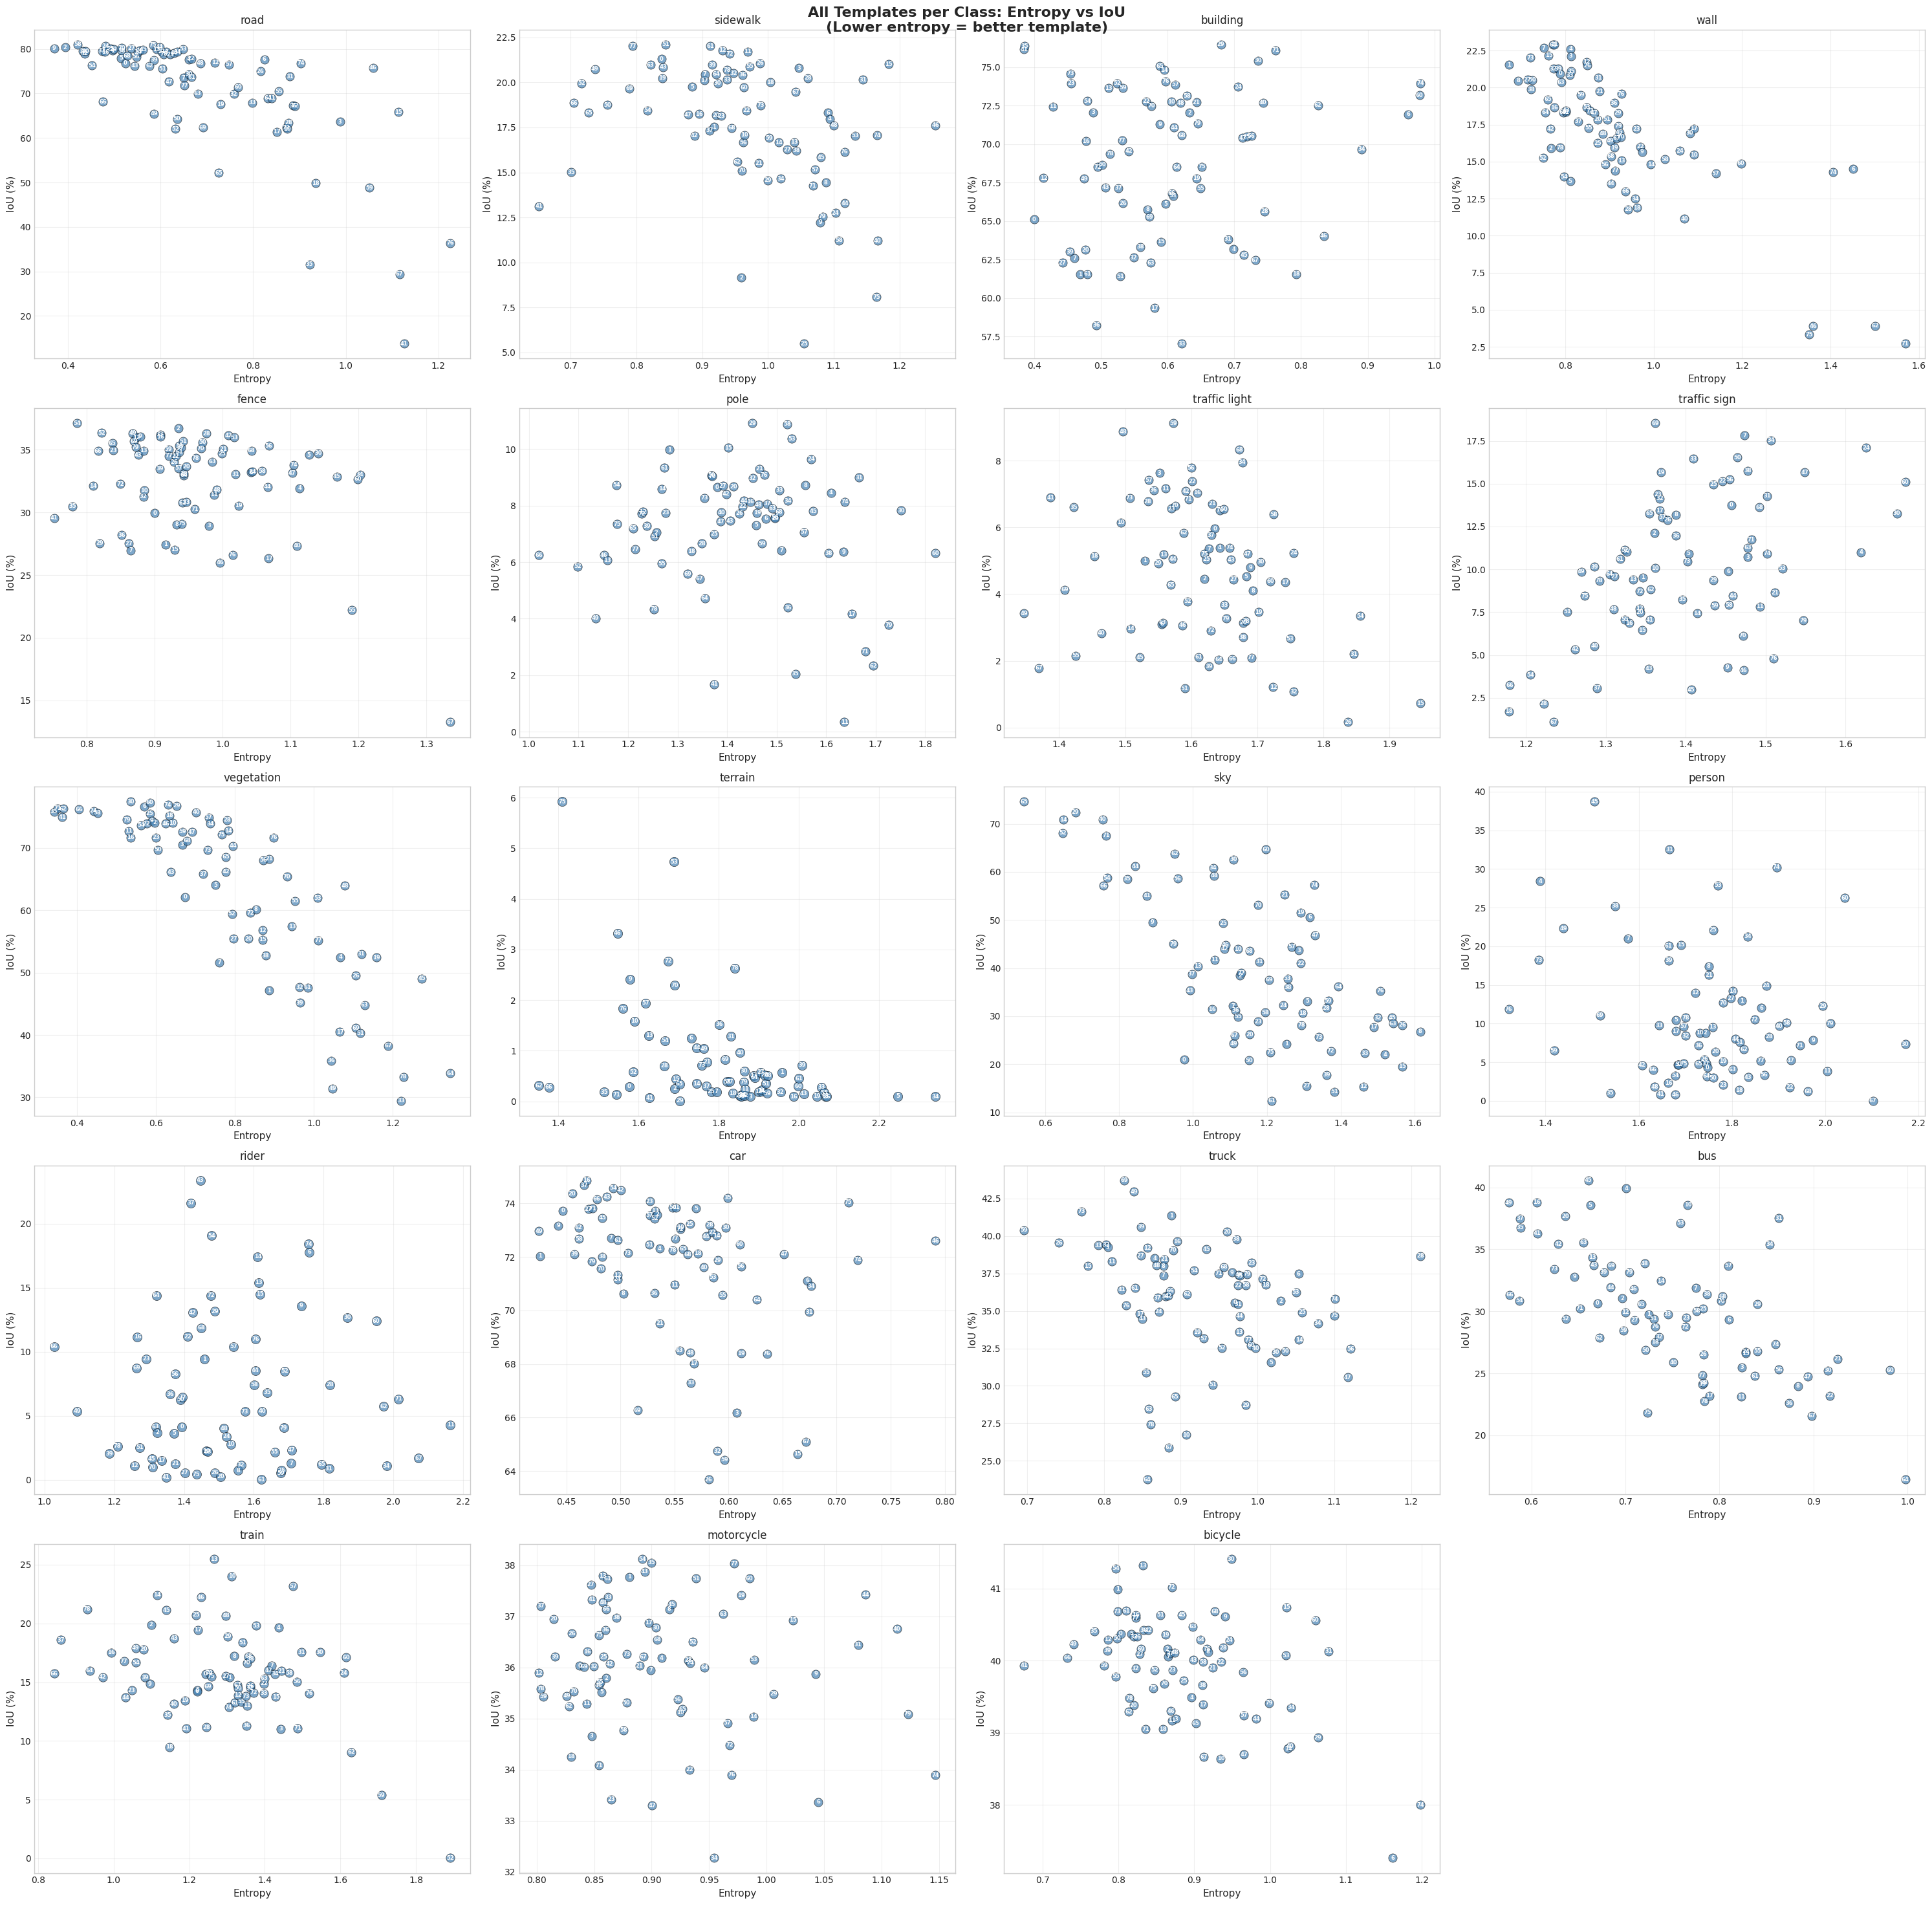

In [11]:
# Load per-template IoU from unified JSON (aggregated from work_dirs/test_template_*/mIoU_results_*.json)
# Run: python scripts/aggregate_iou_results.py  to generate from work_dirs
iou_unified_path = "notebooks/iou_per_template_clipdinoiser_cityscapes.json" if not IN_COLAB else "/content/FLOSS/notebooks/iou_per_template_clipdinoiser_cityscapes.json"
with open(iou_unified_path, "r") as f:
    IOU_PER_TEMPLATE = json.load(f)
# IOU_PER_TEMPLATE: {class_name: {template_id: iou}, "mIoU": {template_id: mean_iou}}
print(f"Loaded per-template IoU from {iou_unified_path}")
print(f"mIoU range: {min(IOU_PER_TEMPLATE['mIoU'].values()):.2f}% - {max(IOU_PER_TEMPLATE['mIoU'].values()):.2f}%")

def visualize_entropy_vs_iou(rankings, iou_dict, metric_name="entropy", top_k=None, save_path=None):
    """
    Create scatter plots showing entropy vs IoU for each class.
    Each point is a template, annotated with template ID.
    top_k: max templates to show per class (None = all templates).
    Skips classes with invalid (inf/nan) entropy values.
    save_path: optional path to save the figure as PNG (e.g., 'scatter_mosaic.png').
    """
    ranking_field = f"{metric_name}_ranking"
    class_names = list(rankings["classes"].keys())
    
    # Filter out classes with invalid entropy values (edge cases)
    valid_classes = []
    skipped_classes = []
    for class_name in class_names:
        class_rankings = rankings["classes"][class_name][ranking_field]
        # Check if the best template has a valid entropy
        if class_rankings and np.isfinite(class_rankings[0][metric_name]):
            valid_classes.append(class_name)
        else:
            skipped_classes.append(class_name)
    
    if skipped_classes:
        print(f"Skipping {len(skipped_classes)} classes with no valid predictions: {skipped_classes}")
    
    n_classes = len(valid_classes)
    if n_classes == 0:
        print("No valid classes to visualize!")
        return
    
    n_cols = 4
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 6 * n_rows))
    if n_classes == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, class_name in enumerate(valid_classes):
        ax = axes[idx]
        class_rankings = rankings["classes"][class_name][ranking_field]
        
        # Filter valid templates only (all if top_k is None)
        templates_to_use = class_rankings[:top_k] if top_k else class_rankings
        valid_templates = [t for t in templates_to_use if np.isfinite(t[metric_name])]
        
        if not valid_templates:
            ax.set_visible(False)
            continue
        
        entropies = [t[metric_name] for t in valid_templates]
        template_ids = [t["template_id"] for t in valid_templates]
        # Per-template IoU: iou_dict[class_name][template_id]
        class_iou = iou_dict.get(class_name, {})
        ious = [class_iou.get(str(tid), class_iou.get(tid, 0.0)) for tid in template_ids]
        
        n_pts = len(valid_templates)
        pt_size = max(40, 250 - n_pts * 2)  # Smaller points when many templates
        font_size = 6 if n_pts > 30 else 8  # Readable font for all vs top-k
        ax.scatter(entropies, ious, s=pt_size, alpha=0.7, c='steelblue', edgecolors='black', linewidth=0.5)
        
        for ent, iou_val, tid in zip(entropies, ious, template_ids):
            ax.annotate(str(tid), (ent, iou_val), fontsize=font_size, ha='center', va='center',
                       fontweight='bold', color='white')
        
        ax.set_xlabel(f"{metric_name.capitalize()}", fontsize=11)
        ax.set_ylabel("IoU (%)", fontsize=11)
        ax.set_title(f"{class_name}", fontsize=12)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_classes, len(axes)):
        axes[idx].set_visible(False)
    
    title = f"All Templates per Class" if top_k is None else f"Top-{top_k} Templates per Class"
    plt.suptitle(f"{title}: {metric_name.capitalize()} vs IoU\n(Lower {metric_name} = better template)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save figure if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

visualize_entropy_vs_iou(rankings, IOU_PER_TEMPLATE, metric_name=METRIC_NAME, top_k=None, save_path="scatter_mosaic.png")

## Compare with Paper Rankings

### Template Selection Comparison

Below we compare the **top-4 template rankings** computed in this notebook against the **pre-computed rankings from the paper**. The comparison shows:

- **Notebook Top-4 (Current Metric)**: Templates selected using the currently selected metric (`METRIC_NAME`) computed on the training set in this session
- **Paper Top-4 (Entropy, Fixed)**: Templates from the pre-computed paper rankings (always entropy-based)
- **Overlap**: How many templates appear in both selections (regardless of order)

The top-4 templates for each class are averaged at the embedding level to create a single expert representation per class, following the approach used in `mmseg/models/segmentors/clip_dinoiser/dinoclip_inferencer.py`.

In [13]:
# Simple comparison: notebook top-4 vs paper top-4 vs true IoU top-4

def load_paper_rankings(dataset="cityscapes", model="clipdinoiser"):
    """Load pre-computed rankings from the paper."""
    if IN_COLAB:
        path = f"/content/FLOSS/rankings/{model}/template_rankings_{model}_{dataset}.json"
    else:
        path = f"rankings/{model}/template_rankings_{model}_{dataset}.json"
    
    try:
        with open(path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Rankings not found at {path}")
        return None

paper_rankings = load_paper_rankings()

def topk_from_ranking(rankings_dict, class_name, metric_name="entropy", top_k=4):
    ranking_field = f"{metric_name}_ranking"
    ranking = rankings_dict["classes"][class_name].get(ranking_field, [])
    return [t["template_id"] for t in ranking if t.get("pixel_percentage", 0) > 0][:top_k]

def topk_true_iou(iou_dict, class_name, top_k=4):
    class_iou = iou_dict.get(class_name, {})
    pairs = [(int(tid), float(iou)) for tid, iou in class_iou.items()]
    pairs.sort(key=lambda x: x[1], reverse=True)
    return [tid for tid, _ in pairs[:top_k]]

if paper_rankings:
    print(f"Metric: {METRIC_NAME} | Top-k: 4")
    print(f"{'Class':12s} | {'Notebook Top-4':18s} | {'Paper Top-4':18s} | {'True Ranking (IoU)':18s}")
    print("-" * 86)

    overlap_paper, overlap_true = [], []

    for cn in CLASS_NAMES:
        nb_ids = topk_from_ranking(rankings, cn, metric_name=METRIC_NAME, top_k=4)
        pp_ids = topk_from_ranking(paper_rankings, cn, metric_name="entropy", top_k=4)
        gt_ids = topk_true_iou(IOU_PER_TEMPLATE, cn, top_k=4)

        print(f"{cn:12s} | {str(nb_ids):18s} | {str(pp_ids):18s} | {str(gt_ids)}")

        overlap_paper.append(len(set(nb_ids) & set(pp_ids)))
        overlap_true.append(len(set(nb_ids) & set(gt_ids)))

    n = len(CLASS_NAMES)
    print("-" * 86)
    print(f"Notebook vs paper overlap avg: {sum(overlap_paper)/n:.2f}/4")
    print(f"Notebook vs true ranking overlap avg: {sum(overlap_true)/n:.2f}/4")
    print("Goal: maximize overlap with True Ranking (IoU) Top-4.")
else:
    print("Paper rankings not available.")

Metric: entropy | Top-k: 4
Class        | Notebook Top-4     | Paper Top-4        | True Ranking (IoU)
--------------------------------------------------------------------------------------
road         | [9, 2, 58, 79]     | [9, 2, 79, 58]     | [58, 75, 24, 44]
sidewalk     | [41, 35, 66, 52]   | [41, 35, 66, 49]   | [51, 77, 61, 12]
building     | [41, 35, 0, 12]    | [35, 41, 0, 11]    | [29, 35, 41, 71]
wall         | [1, 8, 27, 73]     | [7, 1, 50, 73]     | [11, 61, 7, 4]
fence        | [41, 35, 54, 14]   | [66, 41, 35, 54]   | [54, 2, 52, 49]
pole         | [66, 52, 49, 46]   | [66, 52, 49, 46]   | [29, 58, 53, 15]
traffic light | [49, 67, 41, 69]   | [41, 67, 40, 35]   | [59, 48, 68, 34]
traffic sign | [18, 66, 54, 28]   | [18, 67, 28, 55]   | [69, 7, 34, 24]
vegetation   | [35, 71, 41, 62]   | [35, 71, 41, 62]   | [30, 60, 74, 29]
terrain      | [62, 66, 75, 35]   | [8, 42, 23, 7]     | [75, 53, 46, 72]
sky          | [65, 52, 14, 29]   | [65, 52, 14, 54]   | [65, 29, 40, 14]

## Evaluate Rankings on Validation Set (mIoU)

Now we evaluate the quality of the computed rankings by measuring **mIoU on the Cityscapes validation set**.

The idea:
1. **Download validation vision features** and **ground truth segmentation maps** from HuggingFace
2. For each class, select the **top-4 ranked templates** from the rankings computed on the training set and **average them at the embedding level** to create a class-specific expert
3. Use **expert fusion** to make predictions: each pixel is assigned the class whose averaged expert embedding is most confident
4. Compare predictions with ground truth to compute **per-class IoU** and **mIoU**

We also compare against the **default baseline** (averaged template across all 80 templates).

In [14]:
# Download VALIDATION vision features and ground truth from HuggingFace
from PIL import Image

# Number of val images to evaluate (set to None for all 500)
NUM_VAL_IMAGES = None  # Using all 500 validation images for complete evaluation

# Download val vision features
all_val_names = [Path(p).stem for p in val_vision_index['image_paths']]
if NUM_VAL_IMAGES is not None:
    val_names = all_val_names[:NUM_VAL_IMAGES]
    print(f"Using {len(val_names)} of {len(all_val_names)} val images (limited for testing)")
else:
    val_names = all_val_names
    print(f"Using all {len(val_names)} val images")

val_vision_features = download_vision_features(val_names, folder="vision_features_val")
print(f"Loaded {len(val_vision_features)} val vision feature maps")

# Download ground truth segmentation maps
def download_gt_images(gt_names, local_snapshot_dir=LOCAL_HF_SNAPSHOT):
    """Load ground truth label maps from a local HF snapshot."""
    gt_maps = []
    for name in tqdm(gt_names, desc="Loading ground truth (local)"):
        # GT filename: {city}_{seq}_{frame}_gtFine_labelTrainIds.png
        # Vision feature name: {city}_{seq}_{frame}_leftImg8bit
        # Convert vision name to GT name
        gt_filename = name.replace("_leftImg8bit", "_gtFine_labelTrainIds") + ".png"
        path = os.path.join(local_snapshot_dir, "gt_val", gt_filename)
        gt = np.array(Image.open(path))
        gt_maps.append(gt)
    return gt_maps

val_gt_maps = download_gt_images(val_names)
print(f"Loaded {len(val_gt_maps)} ground truth maps")
print(f"GT shape: {val_gt_maps[0].shape} (original resolution)")

Using all 500 val images


Loading vision_features_val (local):   0%|          | 0/500 [00:00<?, ?it/s]

Loaded 500 val vision feature maps


Loading ground truth (local):   0%|          | 0/500 [00:00<?, ?it/s]

Loaded 500 ground truth maps
GT shape: (1024, 2048) (original resolution)


In [15]:
def get_expert_template_ids(rankings, class_names, metric_name="entropy", top_k=4):
    """
    Get the top-k template IDs for each class from the rankings.
    
    Args:
        rankings: rankings dictionary
        class_names: list of class names
        metric_name: name of metric to use (default: "entropy")
        top_k: number of top templates to select per class (default: 4)
    
    Returns:
        List of lists, where each inner list contains top-k template IDs for that class
    """
    ranking_field = f"{metric_name}_ranking"
    expert_ids = []
    for class_name in class_names:
        ranking = rankings["classes"][class_name].get(ranking_field, [])
        if ranking:
            # Get top-k template IDs, filtering those with pixel_percentage > 0
            top_ids = [t["template_id"] for t in ranking if t.get("pixel_percentage", 0) > 0.0][:top_k]
            # Fallback to fewer templates if not enough available
            if not top_ids:
                top_ids = [0]  # fallback to first template
            expert_ids.append(top_ids)
        else:
            expert_ids.append([0])  # fallback to first template
    return expert_ids


def build_inference_bundle(text_features, expert_template_ids, device):
    """Precompute tensors reused across all validation images."""
    per_template = text_features["per_template"].to(device)  # [T, C, D]
    averaged = text_features["averaged"].to(device)  # [C, D]
    C = per_template.shape[1]
    
    expert_classifiers = torch.stack(
        [per_template[expert_template_ids[k], :, :].mean(dim=0) for k in range(C)],
        dim=0,
    )  # [K, C, D]
    
    return {
        "per_template": per_template,
        "averaged": averaged,
        "expert_classifiers": expert_classifiers,
    }


def compute_predictions_expert_fusion(vision_feat, inference_bundle, temperature=0.01):
    """
    Compute segmentation predictions using FLOSS expert fusion (Eq. 6-7 from the paper).
    
    For each class k, builds a full K-class expert classifier W(E_k) by averaging the top-N
    expert template embeddings for ALL K classes (not just class k). Then fuses predictions:
    - For each pixel, find which experts predict their own class of expertise
    - Among those, pick the one with highest confidence
    - If none predicts its own class, fall back to W_CLIP (default averaged classifier)
    
    Args:
        vision_feat: [B, D, H, W] vision feature tensor
        inference_bundle: precomputed tensors from build_inference_bundle()
        temperature: softmax temperature
    
    Returns:
        predictions: [B, H, W] predicted class indices
        fused_probs: [B, C, H, W] fused expert probabilities
    """
    B, _, H, W = vision_feat.shape
    vision_feat = vision_feat / (vision_feat.norm(dim=1, keepdim=True) + 1e-6)
    expert_classifiers = inference_bundle["expert_classifiers"]  # [K, C, D]
    averaged = inference_bundle["averaged"]  # [C, D]
    C, _, D = expert_classifiers.shape
    
    # ---- Step 1-2: Compute all expert maps in one batched conv ----
    expert_weights = expert_classifiers.reshape(C * C, D)  # [K*C, D]
    expert_output = F.conv2d(vision_feat, expert_weights[:, :, None, None])  # [B, K*C, H, W]
    expert_output = expert_output.reshape(B, C, C, H, W).permute(1, 0, 2, 3, 4)  # [K, B, C, H, W]
    expert_probs_all = F.softmax(expert_output / temperature, dim=2)
    
    # ---- Step 3: Compute default W_CLIP predictions (fallback) ----
    default_output = F.conv2d(vision_feat, averaged[:, :, None, None])  # [B, C, H, W]
    default_probs = F.softmax(default_output / temperature, dim=1)
    
    # ---- Step 4: Fusion (Eq. 7), fully vectorized ----
    expert_preds = expert_probs_all.argmax(dim=2)  # [K, B, H, W]
    expert_indices = torch.arange(C, device=vision_feat.device).view(C, 1, 1, 1)
    expert_masks = (expert_preds == expert_indices)  # [K, B, H, W]
    
    gather_idx = torch.arange(C, device=vision_feat.device).view(C, 1, 1, 1, 1).expand(C, B, 1, H, W)
    expert_self_conf = expert_probs_all.gather(2, gather_idx).squeeze(2)  # [K, B, H, W]
    expert_self_conf = expert_self_conf.masked_fill(~expert_masks, float("-inf"))
    
    best_expert = expert_self_conf.argmax(dim=0)  # [B, H, W]
    no_expert_match = ~expert_masks.any(dim=0)  # [B, H, W]
    
    expert_probs_perm = expert_probs_all.permute(1, 3, 4, 0, 2)  # [B, H, W, K, C]
    best_expert_idx = best_expert.unsqueeze(-1).unsqueeze(-1).expand(B, H, W, 1, C)
    selected_expert_probs = torch.gather(expert_probs_perm, 3, best_expert_idx).squeeze(3).permute(0, 3, 1, 2)
    
    fused_probs = torch.where(no_expert_match.unsqueeze(1), default_probs, selected_expert_probs)
    predictions = fused_probs.argmax(dim=1)
    return predictions, fused_probs


def compute_predictions_default(vision_feat, inference_bundle, temperature=0.01):
    """
    Compute segmentation predictions using the default averaged template.
    
    This is the baseline: average all 80 templates then predict.
    
    Args:
        vision_feat: [B, D, H, W] vision feature tensor
        inference_bundle: precomputed tensors from build_inference_bundle()
        temperature: softmax temperature
    
    Returns:
        predictions: [B, H, W] predicted class indices
    """
    averaged = inference_bundle["averaged"]  # [C, D]
    C, D = averaged.shape
    
    vision_feat = vision_feat / (vision_feat.norm(dim=1, keepdim=True) + 1e-6)
    output = F.conv2d(vision_feat, averaged[:, :, None, None])  # [B, C, H, W]
    probs = F.softmax(output / temperature, dim=1)
    predictions = probs.argmax(dim=1)  # [B, H, W]
    return predictions


def compute_miou(predictions_list, gt_list, num_classes, ignore_index=255):
    """
    Compute mean Intersection over Union (mIoU) over a set of images.
    
    Args:
        predictions_list: list of [H_pred, W_pred] prediction tensors
        gt_list: list of [H_gt, W_gt] numpy ground truth arrays
        num_classes: number of classes
        ignore_index: label to ignore (255 for Cityscapes)
    
    Returns:
        per_class_iou: dict of {class_name: IoU}
        miou: mean IoU
    """
    # Confusion matrix where rows=GT and cols=prediction
    confusion = torch.zeros((num_classes, num_classes), dtype=torch.float64)
    
    for pred, gt in zip(predictions_list, gt_list):
        # Upsample prediction to match GT resolution
        if pred.shape != gt.shape:
            pred_tensor = pred.unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W]
            pred_upsampled = F.interpolate(
                pred_tensor, size=gt.shape, mode='nearest'
            ).squeeze().long()
        else:
            pred_upsampled = pred
        
        pred_cpu = pred_upsampled.to(dtype=torch.long, device="cpu")
        gt_t = torch.as_tensor(gt, dtype=torch.long)
        valid_mask = gt_t != ignore_index
        
        if valid_mask.any():
            pred_valid = pred_cpu[valid_mask]
            gt_valid = gt_t[valid_mask]
            hist = torch.bincount(
                gt_valid * num_classes + pred_valid,
                minlength=num_classes * num_classes,
            ).reshape(num_classes, num_classes).to(torch.float64)
            confusion += hist
    
    intersection = torch.diag(confusion)
    union = confusion.sum(dim=1) + confusion.sum(dim=0) - intersection
    iou = torch.full((num_classes,), float("nan"), dtype=torch.float64)
    valid = union > 0
    iou[valid] = (intersection[valid] / union[valid]) * 100.0
    
    per_class_iou = {c: float(iou[c].item()) for c in range(num_classes)}
    valid_ious = iou[torch.isfinite(iou)]
    miou = float(valid_ious.mean().item()) if valid_ious.numel() > 0 else 0.0
    return per_class_iou, miou

print("mIoU evaluation functions defined.")

mIoU evaluation functions defined.


In [16]:
# ============================================================================
# Compute mIoU on validation set using the rankings from the training set
# ============================================================================

# Get expert template IDs from rankings computed on train set (top-4 per class)
expert_ids = get_expert_template_ids(rankings, CLASS_NAMES, metric_name=METRIC_NAME, top_k=4)

inference_bundle = build_inference_bundle(text_features, expert_ids, DEVICE)

# Compute predictions for all val images
print(f"\nComputing predictions on {len(val_vision_features)} val images...")

expert_predictions = []
default_predictions = []

with torch.inference_mode():
    for feat in tqdm(val_vision_features, desc="Computing val predictions"):
        feat_device = feat.to(DEVICE, non_blocking=True)
        
        # Expert fusion predictions (using ranked templates)
        pred_expert, _ = compute_predictions_expert_fusion(
            feat_device, inference_bundle
        )
        expert_predictions.append(pred_expert.squeeze(0).cpu())
        
        # Default baseline predictions (averaged template)
        pred_default = compute_predictions_default(feat_device, inference_bundle)
        default_predictions.append(pred_default.squeeze(0).cpu())

print(f"Done! Computed predictions for {len(expert_predictions)} images.")


Computing predictions on 500 val images...


Computing val predictions:   0%|          | 0/500 [00:00<?, ?it/s]

Done! Computed predictions for 500 images.


In [18]:
# ============================================================================
# Compare with Paper's Rankings (if available)
# ============================================================================

# Compute mIoU for your method and default baseline
expert_per_class_iou, expert_miou = compute_miou(
    expert_predictions, val_gt_maps, NUM_CLASSES
)
default_per_class_iou, default_miou = compute_miou(
    default_predictions, val_gt_maps, NUM_CLASSES
)


if paper_rankings:
    # Get expert template IDs from paper's rankings (top-4 per class)
    paper_expert_ids = get_expert_template_ids(paper_rankings, CLASS_NAMES, metric_name="entropy", top_k=4)
    paper_inference_bundle = build_inference_bundle(text_features, paper_expert_ids, DEVICE)
    
    # Compute predictions using paper's rankings
    paper_predictions = []
    with torch.inference_mode():
        for feat in tqdm(val_vision_features, desc="Computing paper's expert predictions"):
            feat_device = feat.to(DEVICE, non_blocking=True)
            pred, _ = compute_predictions_expert_fusion(
                feat_device, paper_inference_bundle
            )
            paper_predictions.append(pred.squeeze(0).cpu())
    
    # Compute mIoU
    paper_per_class_iou, paper_miou = compute_miou(
        paper_predictions, val_gt_maps, NUM_CLASSES
    )
    
    print(f"Comparison on val set ({len(val_gt_maps)} images)")
    print(f"{'Class':20s} | {'Default':>10s} | {'Your':>10s} | {'Paper':>10s} | {'ΔYour-Paper':>12s}")
    print("-" * 92)
    
    for c_idx, class_name in enumerate(CLASS_NAMES):
        default_iou = default_per_class_iou.get(c_idx, float('nan'))
        expert_iou = expert_per_class_iou.get(c_idx, float('nan'))
        paper_iou = paper_per_class_iou.get(c_idx, float('nan'))
        
        dyp = expert_iou - paper_iou if np.isfinite(expert_iou) and np.isfinite(paper_iou) else float('nan')
        default_str = f"{default_iou:.2f}%" if np.isfinite(default_iou) else "N/A"
        expert_str = f"{expert_iou:.2f}%" if np.isfinite(expert_iou) else "N/A"
        paper_str = f"{paper_iou:.2f}%" if np.isfinite(paper_iou) else "N/A"
        dyp_str = f"{dyp:+.2f}" if np.isfinite(dyp) else "N/A"
        print(f"{class_name:20s} | {default_str:>10s} | {expert_str:>10s} | {paper_str:>10s} | {dyp_str:>12s}")
    
    print("-" * 92)
    print(f"{'mIoU':20s} | {default_miou:9.2f}% | {expert_miou:9.2f}% | {paper_miou:9.2f}% | {expert_miou-paper_miou:+12.2f}")
else:
    print("Paper rankings not available. Skipping comparison.")

Computing paper's expert predictions:   0%|          | 0/500 [00:00<?, ?it/s]

Comparison on val set (500 images)
Class                |    Default |       Your |      Paper |  ΔYour-Paper
--------------------------------------------------------------------------------------------
road                 |     78.74% |     73.17% |     73.39% |        -0.22
sidewalk             |     17.28% |     17.93% |     17.93% |        +0.00
building             |     69.18% |     75.77% |     76.14% |        -0.37
wall                 |     24.94% |     26.64% |     26.30% |        +0.33
fence                |     26.20% |     23.52% |     25.04% |        -1.52
pole                 |     10.94% |     10.43% |     10.34% |        +0.09
traffic light        |      4.76% |      4.88% |      5.95% |        -1.07
traffic sign         |     12.09% |      9.28% |     14.57% |        -5.29
vegetation           |     68.56% |     75.50% |     75.73% |        -0.22
terrain              |      0.05% |      0.00% |      0.00% |        +0.00
sky                  |     38.89% |     60.43% 

---

## Challenge

Can you find a better unsupervised metric than entropy? Edit `compute_custom_metric()` and try to beat our results!

Note: **rankings are computed on the training set without any labels**, then evaluated on the validation set with ground truth. Keep this in mind when designing your metric: better metrics should rank templates with higher IoU near the top.